<a id='toc'></a>
# Список тестов по бригадам:

1. [Расчет процента подвязки между бригадами и локомотивами.](#perc_assign)
2. [Расчет процента запланированных бригад от общего количества бригад на входе планировщика.](#perc_assign2)
3. [Распределение между реальными и фейковыми бригадами в результатах планирования.](#real_fake)
4. [Составление списка станций и участков, на которых не состоялась подвязка бригады.](#no_assign)
5. [Проверка переработки бригад.](#overwork)   
6. [Проверка "скачков" бригад между станциями.](#leaps)
7. [Анализ времен стоянок поездов для смены бригады.](#stop_time)
8. [Анализ времен отдыха бригад.](#rest_time)
9. [Проверка корректности времен явки бригад во входных данных](#ready_time)
10. [Проверка смены бригад на корректных станциях](#change)
11. [Проверка отправления бригад до времени явки](#presence)
12. [Проверка планирования бригад до времени начала планирования](#before_current_time)
13. [Проверка планируемых явок бригад](#presenting)
14. [Проверка использования бригад после засылки пассажирами](#check_useful_assign)
  1. [Бригады, бесцельно отправляемые пассажирами](#only_pass)
  2. [Бригады, у которых запланирована только явка](#only_presence)
15. [Проверка подвязки негрузовых бригад](#pass_teams_in_plan)

### Константы и настройки

In [95]:
report = ''
FOLDER = 'resources/'
REPORT_FOLDER = 'report/'
PRINT = True

In [96]:
time_format = '%b %d, %H:%M'
def sprint(s):
    print(s.to_string(index=False))
    
#def scount(df):
#    return scount(df, df.columns[0])
    
def scount(df, col):
    return df[col].drop_duplicates().count() if col in df.columns else 0

def nice_time(t):
    return time.strftime(time_format, time.localtime(t)) if t > 0 else ''

### Функции для экспорта в HTML

In [97]:
def add_line(line, p=PRINT):    
    global report        
    if p:                
        if type(line) == pd.core.frame.DataFrame:
            print(line.to_string(index=False))
        elif type(line) == pd.core.series.Series:
            print(line.to_string())
        else:
            print(line)
    if type(line) == pd.core.frame.DataFrame:        
        report += ('%s<br>' % line.to_html(index=False))
    elif type(line) == pd.core.series.Series:
        report += ('%s<br>' % line.to_frame().reset_index().to_html(index=False))
    else:
        if line[:2] == '\n':
            line_rep = line[2:]
        else:
            line_rep = line
        report += ('%s<br>' % line_rep)
    
def add_header(header, h=4, p=PRINT):
    global report
    report += ('<h%d>%s</h%d>' % (h, header, h))
    if p:
        print(header)

def add_image(filename):
    global report
    report += ('<img src="%s" alt="%s" height="40%%">' % (filename, filename))

def create_report(filename):
    global report
    report = report.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html_string = '''
        <html>
            <head>
                <link rel="stylesheet" href="skeleton.css">
                <style>body{ margin:20 20; background:whitesmoke; }
                table {table-layout : fixed}
                </style>
            </head>
            <body>                
                %s
            </body>
        </html>''' % (report)
    f = open(filename,'w', encoding='utf-8-sig')
    f.write(html_string)
    f.close()
    print('Отчет сформирован: %s' % filename)

## Загрузка и подготовка данных

In [98]:
import numpy as np
import pandas as pd
import time, datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

pd.set_option('max_rows', 50)

time_format = '%b %d, %H:%M'

start_time = time.time()
current_time = pd.read_csv(FOLDER + 'current_time.csv').current_time[0]
twr          = pd.read_csv(FOLDER + 'team_work_region.csv', converters={'twr':str})
links        = pd.read_csv(FOLDER + 'link.csv')
stations     = pd.read_csv(FOLDER + 'station.csv', converters={'station':str})
train_info   = pd.read_csv(FOLDER + 'train_info.csv', converters={'train': str, 'st_from':str, 'st_to':str})
train_plan   = pd.read_csv(FOLDER + 'slot_train.csv', converters={'train': str, 'st_from':str, 'st_to':str})
loco_info    = pd.read_csv(FOLDER + 'loco_attributes.csv', converters={'train':str, 'loco':str})
loco_plan    = pd.read_csv(FOLDER + 'slot_loco.csv', converters={'train':str, 'loco':str, 'st_from':str, 'st_to':str})
team_info    = pd.read_csv(FOLDER + 'team_attributes.csv', converters={'team':str,'depot':str, 'oper_location':str, \
                                                                 'st_from':str, 'st_to':str, 'loco':str, 'depot_st':str})
team_plan    = pd.read_csv(FOLDER + 'slot_team.csv', converters={'team':str,'loco':str, 'st_from':str, 'st_to':str})
loco_series  = pd.read_csv(FOLDER + 'loco_series.csv')

team_info.regions = team_info.regions.apply(literal_eval)
st_names = stations[['station', 'name', 'esr']].drop_duplicates().set_index('station')
print('Время составления отчета:', time.strftime(time_format, time.localtime()))
print('Время запуска планировщика: %s (%d)' % (time.strftime(time_format, time.localtime(current_time)), current_time))

Время составления отчета: Jul 07, 17:26
Время запуска планировщика: Jul 06, 14:41 (1467805287)


In [99]:
# Мержим таблицы _plan и _info для поездов, локомотивов и бригад
# Добавляем во все таблицы названия станций на маршруте и времена отправления/прибытия в читабельном формате

def add_info(df):    
    if 'st_from' in df.columns:
        df['st_from_name'] = df.st_from.map(st_names.name)
    if 'st_to' in df.columns:
        df['st_to_name'] = df.st_to.map(st_names.name)
    if 'time_start' in df.columns:
        df['time_start_f'] = df.time_start.apply(lambda x: nice_time(x))
    if 'time_end' in df.columns:
        df['time_end_f'] = df.time_end.apply(lambda x: nice_time(x))
    if 'oper_location' in df.columns:
        df['oper_location_name'] = df.oper_location.map(st_names.name)    
        df.oper_location_name.fillna(0, inplace=True)
    if ('oper_location' in df.columns) & ('st_from' in df.columns) & ('st_to' in df.columns):        
        df['loc_name'] = df.oper_location_name
        df.loc[df.loc_name == 0, 'loc_name'] = df.st_from_name + ' - ' + df.st_to_name
    
add_info(train_plan)
add_info(loco_plan)
add_info(team_plan)
add_info(loco_info)
add_info(team_info)
train_plan = train_plan.merge(train_info, on='train', suffixes=('', '_info'), how='left')
loco_plan = loco_plan.merge(loco_info, on='loco', suffixes=('', '_info'), how='left')
team_plan = team_plan.merge(team_info, on='team', suffixes=('', '_info'), how='left')
team_plan['team_type'] = team_plan.team.apply(lambda x: 'Реальная' if str(x)[0] == '2' else 'Фейковая')

In [100]:
add_line('Время сбора данных и запуска планировщика: %s' % time.strftime(time_format, time.localtime(current_time)))

Время сбора данных и запуска планировщика: Jul 06, 14:41


<a id='perc_assign'></a>
## Расчет процента подвязки между локомотивами и бригадами [ToC](#toc)

In [101]:
add_header('Расчет процента подвязки между локомотивами и бригадами', h=2, p=False)

In [102]:
def count_real_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             ((loco_plan.team == -1) | (loco_plan.team_type == 'Фейковая')) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без реальных бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    
    
def count_assign_percent(hor):
    loco_no_team = loco_plan.loc[(loco_plan.time_start < current_time + hor) &
                             (loco_plan.team == -1) &
                             (loco_plan.state.isin([0, 1]))]
    loco_n = len(loco_plan.drop_duplicates(subset=['loco']).index)
    loco_no_team_n = len(loco_no_team.loco.drop_duplicates().index)
    percent = 100 - np.round((100 * loco_no_team_n / loco_n), 2)
    add_line('Локомотивов без бригад на горизонте %2.d часов: %d из %d (процент подвязки %d%%)' %
          (hor / 3600, loco_no_team_n, loco_n, percent))
    count_real_assign_percent(hor)   

    
if 'team' not in loco_plan.columns:
    loco_plan = loco_plan.set_index(['loco', 'time_start']).join(team_plan.loc[team_plan.state == 1, \
                                                                ['team', 'loco', 'time_start', 'team_type']].\
                                                                 set_index(['loco', 'time_start'])).reset_index()    
    loco_plan.team.fillna(-1, inplace=True)

count_assign_percent(6 * 3600)
count_assign_percent(12 * 3600)
count_assign_percent(24 * 3600)

Локомотивов без бригад на горизонте  6 часов: 70 из 1573 (процент подвязки 95%)
Локомотивов без реальных бригад на горизонте  6 часов: 187 из 1573 (процент подвязки 88%)
Локомотивов без бригад на горизонте 12 часов: 110 из 1573 (процент подвязки 93%)
Локомотивов без реальных бригад на горизонте 12 часов: 329 из 1573 (процент подвязки 79%)
Локомотивов без бригад на горизонте 24 часов: 209 из 1573 (процент подвязки 86%)
Локомотивов без реальных бригад на горизонте 24 часов: 769 из 1573 (процент подвязки 51%)


<a id='perc_assign2'></a>
## Расчет процента запланированных бригад от общего количества [ToC](#toc)

In [103]:
add_header('Расчет процента запланированных бригад от общего количества бригад на входе', h=2, p=False)

Всего бригад, запланированных с локомотивами в работе: 4300 из 4714 (91.22%)


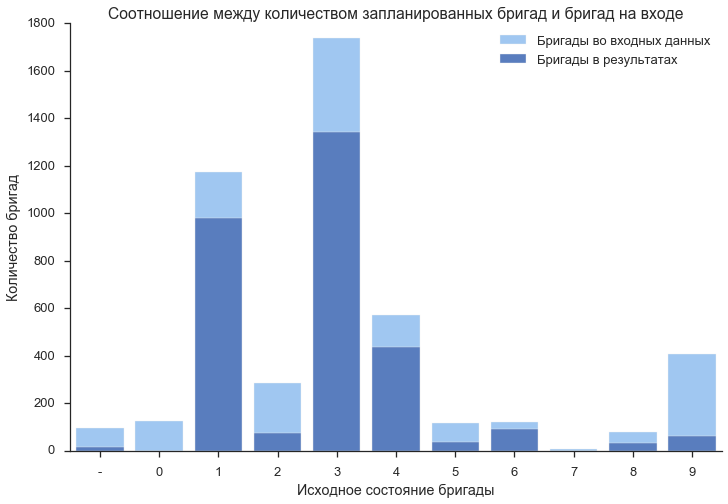

In [104]:
# team_planned = team_plan.loc[team_plan.state.isin([0, 1])]
team_assigned = team_plan.loc[team_plan.state.isin([1])]
team_assigned_n = len(team_assigned.drop_duplicates(subset=['team']).index)
team_total_n = len(team_info.team.index)
team_assigned_percent = team_assigned_n / team_total_n
add_line('Всего бригад, запланированных с локомотивами в работе: %d из %d (%.2f%%)' %
      (team_assigned_n, team_total_n, 100 * team_assigned_percent))
team_info['is_assign'] = team_info.team.isin(team_assigned.team)
assign_states = team_info.loc[team_info.is_assign == True, ['team', 'state']].state.astype(str).value_counts().to_frame()
initial_states = team_info.state.value_counts().to_frame()
initial_states.columns=['Бригады во входных данных']
assign_states.columns=['Бригады в результатах']
states = initial_states.join(assign_states)
states.fillna(0, inplace=True)

sns.set_style("ticks")
sns.set_context("talk")
sns.set_color_codes("pastel")
fig = plt.figure()
sns.barplot(x='index', y='Бригады во входных данных', data=states.sort_index().reset_index(), 
            color="b", label='Бригады во входных данных')
sns.set_color_codes('muted')
ax = sns.barplot(x='index', y='Бригады в результатах', data=states.sort_index().reset_index(), 
            color="b", label='Бригады в результатах')
ax.legend(ncol=1, loc="upper right", frameon=False)
ax.set(ylabel='Количество бригад', xlabel='Исходное состояние бригады', 
       title='Соотношение между количеством запланированных бригад и бригад на входе')
sns.despine()
filename = 'team_usage.png'
plt.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='real_fake'></a>
### Распределение реальных и фейковых бригад в результатах планирования

In [105]:
add_header('Распределение реальных и фейковых бригад в результатах планирования', h=2, p=False)

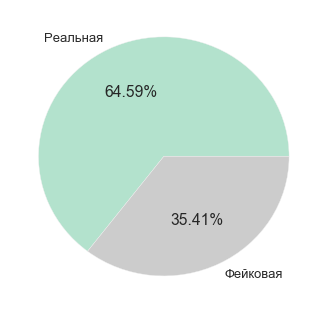

In [106]:
f = team_plan.drop_duplicates(subset=['team']).team_type.value_counts()
fig = plt.figure()
ax = f.plot(kind='pie', colormap='Pastel2', figsize=(5,5), autopct='%.2f%%')
ax.set_ylabel('')
#plt.show()
filename = 'real_fake_teams_ratio.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='no_assign'></a>
## Cтанции и участки, на которых не состоялась подвязка бригады [ToC](#toc)

In [107]:
add_header('Станции и участки, на которых не состоялась подвязка бригады', h=2, p=False)

In [108]:
horizon = 6 * 3600
add_line('Горизонт анализа: %d часов' % (horizon / 3600), p=False)
loco_mask = (loco_plan.time_start < current_time + horizon)

In [109]:
# Добавляем признак первой станции на маршруте локомотива, где не была подвязана бригада
loco_plan.loc[loco_plan.state == 4, 'team'] = 0
loco_plan['no_team_start'] = (loco_plan.team == -1) & \
                             ((loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1)))
    
loco_cols = ['loco', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'team', 'no_team_start']
fail_team_assign_locos = loco_plan.loc[loco_mask & (loco_plan.no_team_start == True)]
fail_team_assign_stations = fail_team_assign_locos.st_from_name.value_counts().head(10)
fail_team_assign_tracks = fail_team_assign_locos.groupby('st_from_name').st_to_name.value_counts().\
                            sort_values(ascending=False).head(10)
add_header('Станции, на которых не удалось подвязать бригады под локомотив (первые 10):')
add_line(fail_team_assign_stations)
add_header('\nУчастки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):')
add_line(fail_team_assign_tracks)

Станции, на которых не удалось подвязать бригады под локомотив (первые 10):
КРАСНОЯРСК-ВОСТОЧНЫЙ                  13
ИЛАНСКАЯ                              12
МОГОЧА                                 6
КОРШУНИХА-АНГАРСКАЯ                    4
АНДРИАНОВСКАЯ                          3
ГОРХОН                                 3
БУРЕЯ                                  2
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ     2
УСТЬ-ИЛИМСК                            2
ЛЕНА                                   2

Участки планирования, на которых не удалось подвязать бригады под локомотив (первые 10):
st_from_name                        st_to_name
ИЛАНСКАЯ                            ЗАОЗЕРНАЯ     12
КРАСНОЯРСК-ВОСТОЧНЫЙ                ЗЫКОВО        12
МОГОЧА                              АМАЗАР         6
КОРШУНИХА-АНГАРСКАЯ                 ХРЕБТОВАЯ      4
АНДРИАНОВСКАЯ                       АНГАСОЛКА      3
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ  СЕЛИХИН        2
ЗАОЗЕРНАЯ                           УЯР            2
ЛЕНА  

In [110]:
#st_name = fail_team_assign_stations.head(1).index[0]
st_name = 'КРАСНОЯРСК-ВОСТОЧНЫЙ'
bad_locos = loco_plan.loc[loco_mask & (loco_plan.st_from_name == st_name) & (loco_plan.no_team_start == True)]
if not bad_locos.empty:
    add_header('Локомотивы, к которым не была подвязана бригада на станции %s, по направлениям:' % st_name)
    add_line(bad_locos.st_to_name.value_counts())

Локомотивы, к которым не была подвязана бригада на станции КРАСНОЯРСК-ВОСТОЧНЫЙ, по направлениям:
ЗЫКОВО                 12
КРАСНОЯРСК-СЕВЕРНЫЙ     1


<a id='overwork'></a>
## Проверка переработки бригад [ToC](#toc)

In [111]:
add_header('Бригады с переработкой', h=2, p=False)

#### Вычисляем последнее время явки для каждого участка на маршруте

In [112]:
# В поле presence прописываем последнюю явку бригады из входных данных
team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: max(x))
team_info['presence_norm'] = team_info.presence.apply(lambda x: time.strftime(time_format, time.localtime(x)) if x>0 else x)
team_plan['info_presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['info_presence_norm'] = team_plan.info_presence\
            .apply(lambda x: time.strftime(time_format, time.localtime(x)) if x>0 else x)
team_plan['info_presence'] = team_plan.info_presence.apply(lambda x: [] if np.isnan(x) else [int(x)])

# Собираем все запланированные явки бригады. 
# Если ни одной явки не запланировано, то проставляем фейковые явки: время первого отправления (после отдыха) минус 1 час
team_plan['start_trip'] = team_plan.state.isin([0, 1]) \
                & ((team_plan.team != team_plan.team.shift(1)) | (team_plan.state.shift(1) == 4))
team_plan['fake_plan_presence'] = team_plan.team.map(team_plan[team_plan.start_trip].groupby('team').time_start.unique() - 3600)
team_plan.fake_plan_presence.fillna(0, inplace=True)
team_plan['fake_plan_presence'] = team_plan.fake_plan_presence.apply(lambda x: [] if (type(x) == int) else x)
team_plan['plan_presence'] = team_plan.team.map(team_plan[team_plan.state == 2].groupby('team').time_start.unique())
team_plan.plan_presence.fillna(0, inplace=True)
team_plan['plan_presence'] = team_plan.plan_presence.apply(lambda x: [] if (type(x) == int) else x)

In [113]:
def get_curr_presence(row):
    real_presence = np.concatenate([row.info_presence, row.plan_presence])   
    if len(real_presence) > 0:
        presence_list = real_presence
    elif len(row.fake_plan_presence) > 0:
        presence_list = row.fake_plan_presence
    else:
        return current_time
        
    t = row.time_start
    b = [x for x in presence_list if x <= t]
    return int(max(b)) if b != [] else (row.fake_plan_presence[0] if len(row.fake_plan_presence) > 0 else current_time)   
    
    
team_plan['curr_presence'] = team_plan.apply(lambda row: get_curr_presence(row), axis=1)
cols = ['team', 'st_from_name', 'time_start', 'state', 'info_presence', 'info_presence_norm', 
        'plan_presence', 'fake_plan_presence', 'curr_presence']
team_plan[team_plan.team == '777700001868'][cols]

,team,st_from_name,time_start,state,info_presence,info_presence_norm,plan_presence,fake_plan_presence,curr_presence


#### Составляем таблицу team_trips с поездками бригад

In [114]:
cols = ['team', 'state', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'loco', 'start_trip', 'end_trip', 
        'start_trip_time', 'end_trip_time']
team_plan['end_trip'] = ((team_plan.team != team_plan.team.shift(-1)) & (team_plan.state == 1)) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(-1).isin([0, 2, 4])))
team_plan.loc[team_plan.end_trip == True, 'end_trip_time'] = team_plan.time_end
team_plan['start_trip'] = ((team_plan.state == 1) & (team_plan.team != team_plan.team.shift(1))) | \
                        ((team_plan.state == 1) & (team_plan.state.shift(1).isin([0, 2, 4])))
team_plan.loc[team_plan.start_trip == True, 'start_trip_time'] = team_plan.time_start
start_trips = team_plan.dropna(subset=['start_trip_time'])
end_trips = team_plan.dropna(subset=['end_trip_time'])

frames = [start_trips.reset_index()[['team', 'state', 'st_from_name', 'start_trip_time']],
          end_trips.reset_index()[['st_to_name', 'end_trip_time', 'curr_presence']]]
team_trips = pd.concat(frames, axis=1, ignore_index=True)
team_trips.columns = ['team', 'state', 'st_from_name', 'time_start', 'st_to_name', 'time_end', 'curr_presence']
add_info(team_trips)
team_trips['curr_presence_norm'] = team_trips.curr_presence.apply(lambda x: time.strftime(time_format, time.localtime(x)))

In [115]:
team_trips[team_trips.team == '777700001868']

,team,state,st_from_name,time_start,st_to_name,time_end,curr_presence,time_start_f,time_end_f,curr_presence_norm


#### Загружаем нормы рабочего времени и составляем таблицу по нормам для каждой бригады

In [116]:
WORK_TIME_LIMIT = 11 #hours

In [117]:
def get_cmp(row):
    d, l = row.depot, row.link    
    try:
        res = trd.ix[d].link.apply(lambda x: len(np.intersect1d(x, l))).idxmax()        
    except:
        res = -1
    return res

team_region = pd.read_csv(FOLDER + 'team_region.csv', dtype={'st_from':str, 'st_to':str, 'depot':str})
add_info(team_region)
team_region['link'] = list(zip(team_region.st_from, team_region.st_to))
team_plan['link'] = list(zip(team_plan.st_from, team_plan.st_to))
tr_links = team_region.groupby(['team_region', 'depot']).link.unique().to_frame().reset_index()
if not tr_links.empty:
    trd = tr_links.set_index(['depot', 'team_region'])
else:
    trd = tr_links
team_links = team_plan[team_plan.state.isin([0, 1])].groupby(['team', 'depot']).link.unique().to_frame().reset_index()
team_links['team_region'] = team_links.apply(lambda row: get_cmp(row), axis=1)

team_links['tr_depot'] = list(zip(team_links.team_region, team_links.depot))
team_region['tr_depot'] = list(zip(team_region.team_region, team_region.depot))
team_links['time_f'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_f)
team_links['time_b'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_b)
team_links['time_wr'] = team_links.tr_depot.map(team_region.drop_duplicates('tr_depot').set_index('tr_depot').time_wr)
#team_links.head()

In [118]:
time_limit = team_links[['team', 'time_f', 'time_b', 'time_wr']]
time_limit.head()

,team,time_f,time_b,time_wr
0,200200032910,NaN,NaN,NaN
1,200200033796,NaN,NaN,NaN
2,200200034977,NaN,NaN,NaN
3,200200035773,NaN,NaN,NaN
4,200200036640,NaN,NaN,NaN


#### Вычисляем переработки, предварительно удалив выбросы

In [119]:
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'curr_presence_norm']
outliers = team_trips[team_trips.curr_presence < current_time - 24 * 3600]
#outliers = team_trips[team_trips.info_presence < current_time - 24 * 3600]
outliers_n = outliers.team.count()
add_header('Всего %d бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:' % outliers_n)
add_line(outliers.sort_values('curr_presence_norm').head(10 if outliers_n > 20 else outliers_n)[cols])

Всего 2 бригад с явно некорретными (более суток назад) временами последеней явки. Примеры:
         team st_from_name   st_to_name   time_start_f     time_end_f curr_presence_norm
 200200136231   НОВОНЕЖИНО  СМОЛЯНИНОВО  Jul 06, 14:41  Jul 06, 15:06      Jul 05, 01:00
 200200064651      ТАКСИМО   НОВЫЙ УОЯН  Jul 06, 09:55  Jul 06, 14:34      Jul 05, 10:08


In [120]:
pd.set_option('display.max_colwidth', 25)
# Оставляем только корректные бригады
team_trips = team_trips[(team_trips.team.isin(outliers.team) == False) & (team_trips.time_start < current_time + 24 * 3600)]
team_trips['time_limit'] = team_trips.team.map(time_limit.set_index('team').time_f)
team_trips['time_limit_no_rest'] = team_trips.team.map(time_limit.set_index('team').time_wr)
team_trips.time_limit.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips.time_limit_no_rest.fillna(WORK_TIME_LIMIT * 3600, inplace=True)
team_trips[['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'time_limit', 'time_limit_no_rest']].head()

,team,st_from_name,st_to_name,curr_presence_norm,time_start_f,time_end_f,time_limit,time_limit_no_rest
0,200200171649,ВЫСОКОГОРНАЯ,КОМСОМОЛЬСК-НА-АМУРЕ-...,"Jul 07, 02:22","Jul 07, 03:52","Jul 07, 11:00",39600,39600
1,200200251206,КАРЫМСКАЯ,ЧИТА I,"Jul 06, 17:29","Jul 06, 19:35","Jul 06, 21:23",39600,39600
2,200200151664,ХИЛОК,ЧИТА I,"Jul 06, 16:16","Jul 06, 17:25","Jul 06, 22:46",39600,39600
3,200200151664,ЧИТА I,ХИЛОК,"Jul 07, 03:00","Jul 07, 04:20","Jul 07, 09:20",39600,39600
4,200200199014,СКОВОРОДИНО,ТЫНДА,"Jul 07, 05:19","Jul 07, 06:00","Jul 07, 13:38",39600,39600


In [121]:
team_trips['work_time'] = np.round(((team_trips.time_end - team_trips.curr_presence) / 3600), 2)
#team_trips['overtime'] = team_trips.work_time.apply(lambda x: np.max([x - WORK_TIME_LIMIT, 0]))
team_trips['overtime'] = np.round((team_trips.time_end - team_trips.curr_presence - team_trips.time_limit) / 3600, 2)
team_trips['overtime'] = team_trips.overtime.apply(lambda x: 0 if x < 0 else x)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_end_f', 'overtime' ]
add_header('Количество бригад с переработкой (показаны первые 10 интервалов):')
add_line(pd.cut(team_trips.overtime, bins=np.arange(int(team_trips.overtime.max()) + 2), include_lowest=False)\
      .value_counts().head(10).sort_index())

Количество бригад с переработкой (показаны первые 10 интервалов):
(0, 1]      137
(1, 2]       52
(2, 3]       25
(3, 4]       14
(4, 5]       21
(5, 6]       10
(6, 7]       10
(8, 9]        7
(9, 10]       5
(10, 11]      6


In [122]:
pd.set_option('display.max_colwidth', 25)
cols = ['team', 'st_from_name', 'st_to_name', 'curr_presence_norm', 'time_start_f', 'time_end_f', 'overtime' ]
add_header('\nБригады с переработкой больше 2 часов (всего %d):' % len(team_trips.loc[team_trips.overtime > 2].index))
add_line(team_trips.loc[team_trips.overtime > 2, cols].sort_values('overtime', ascending=False).head(20))

add_header('\nРаспределение бригад с переработкой больше 2 часов по типу:')
team_trips['team_type'] = team_trips.team.map(team_plan.drop_duplicates('team').set_index('team').team_type)
add_line(team_trips.loc[team_trips.overtime > 2].team_type.value_counts())


Бригады с переработкой больше 2 часов (всего 108):
         team  st_from_name                st_to_name curr_presence_norm   time_start_f     time_end_f  overtime
 200200188957      ИЛАНСКАЯ                  ИЛАНСКАЯ      Jul 06, 06:51  Jul 06, 23:29  Jul 07, 10:44     16.89
 200200209057      УЛАН-УДЭ     ИРКУТСК-СОРТИРОВОЧНЫЙ      Jul 06, 05:20  Jul 06, 14:55  Jul 07, 07:36     15.28
 200200210446   НОВЫЙ УРГАЛ                     ТЫРМА      Jul 06, 03:00  Jul 06, 22:30  Jul 07, 04:09     14.16
 200200142325          ЗИМА                    ТАЙШЕТ      Jul 07, 11:07  Jul 07, 11:47  Jul 08, 12:05     13.96
 200200221525  БЕЛОГОРСК II                     БУРЕЯ      Jul 07, 02:48  Jul 07, 03:28  Jul 08, 03:04     13.27
 200200140106  БЕЛОГОРСК II                   ОБЛУЧЬЕ      Jul 07, 00:34  Jul 07, 01:15  Jul 07, 23:21     11.77
 200200257814          ИРБА              БОЛЬШАЯ ИРБА      Jul 06, 12:30  Jul 07, 10:10  Jul 07, 10:28     10.97
 210202160690         ТЫНДА                 

In [123]:
team_ids = team_trips.loc[team_trips.overtime > 2].sort_values('overtime', ascending=False).team.values[:3]
#team_id = '777700001868'
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'time_start_f', 'time_end_f', 'loco']
team_info['depot_time_f'] = team_info.depot_time.apply(nice_time)
team_info['return_time_f'] = team_info.return_time.apply(nice_time)
team_info['depot_st_name'] = team_info.depot_st.map(st_names.name)
add_header('Примеры планов бригад с переработками:')
for team_id in team_ids:
    add_line('Бригада %s:' % team_id)
    add_line(team_info[team_info.team == team_id][['team', 'depot_st_name', 'depot_time_f', 'return_time_f', 'state', 'loco', 'loc_name']])
    add_line(team_plan[team_plan.team == team_id][cols])
    add_line('')

Примеры планов бригад с переработками:
Бригада 200200188957:
         team depot_st_name   depot_time_f  return_time_f state          loco  loc_name
 200200188957      ИЛАНСКАЯ  Jul 06, 06:51  Jul 05, 04:05     6  200200061057  ИЛАНСКАЯ
         team st_from_name st_to_name  state   time_start_f     time_end_f          loco
 200200188957     ИЛАНСКАЯ  ЗАОЗЕРНАЯ      1  Jul 06, 23:29  Jul 07, 01:28  200200057263
 200200188957    ЗАОЗЕРНАЯ        УЯР      1  Jul 07, 01:28  Jul 07, 01:59  200200057263
 200200188957          УЯР  ЗАОЗЕРНАЯ      1  Jul 07, 08:20  Jul 07, 08:51  200200092648
 200200188957    ЗАОЗЕРНАЯ   ИЛАНСКАЯ      1  Jul 07, 08:51  Jul 07, 10:44  200200092648

Бригада 200200209057:
         team depot_st_name   depot_time_f  return_time_f state          loco  loc_name
 200200209057      УЛАН-УДЭ  Jul 05, 08:30  Jul 06, 05:20     6  200200089310  УЛАН-УДЭ
         team          st_from_name             st_to_name  state   time_start_f     time_end_f          loco
 20020020

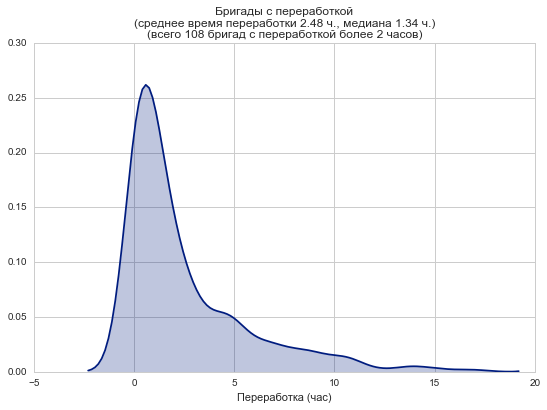

In [124]:
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_color_codes('dark')
fig = plt.figure()
to_hist = team_trips.loc[team_trips.overtime > 0].overtime
ax = sns.distplot(to_hist, bins=20, color='b', hist=False, kde_kws={'shade':True})
title = '''Бригады с переработкой
(среднее время переработки %.2f ч., медиана %.2f ч.)
(всего %d бригад с переработкой более 2 часов)''' % \
            (to_hist.mean(), to_hist.median(), len(team_trips.loc[team_trips.overtime > 2].index))
ax.set(title=title, xlabel='Переработка (час)')
#sns.despine()
filename = 'team_overwork.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

<a id='leaps'></a>
## Скачки по станциям на маршруте бригад [ToC](#toc)

In [125]:
add_header('Скачки по станциям на маршруте бригад', h=2, p=False)

### Скачки внутри планируемого маршрута бригад

In [126]:
pd.set_option('display.max_colwidth', 20)
team_cols = ['team', 'st_from_name', 'st_to_name', 'next_st', 'time_start_f', 'time_end_f', 'state', 'state_info']
team_plan['is_end'] = team_plan.team != team_plan.team.shift(-1)
team_plan['next_st'] = team_plan.st_from_name.shift(-1)
team_leaps = team_plan.loc[(team_plan.is_end == False) 
                           & (team_plan.st_to_name != team_plan.next_st)
                           & (team_plan.st_to_name.notnull())
                           & (team_plan.next_st.notnull()), team_cols]
team_leaps_n = len(team_leaps.team.drop_duplicates().index)
add_header('\nВсего бригад, у которых есть скачки на маршруте: %d' % team_leaps_n)
add_header('Всего скачков на маршруте бригад: %d (показаны первые 10):' % len(team_leaps.index))
add_line(team_leaps.head(20))

add_header('\nСтанции, на которых наблюдаются скачки (первые 5):')
add_line(team_leaps.st_to_name.value_counts().head())

# Пример маршрута такой бригады (подставить id из предыдущего вывода):
team_cols2 = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'state_info']
#team_id = '200200164017'
if not team_leaps.empty:
    team_id = team_leaps.iloc[0].team
    add_header('\nМаршрут бригады %s:' % team_id)
    add_line(team_plan.loc[team_plan.team == team_id, team_cols2])


Всего бригад, у которых есть скачки на маршруте: 152
Всего скачков на маршруте бригад: 162 (показаны первые 10):
         team         st_from_name           st_to_name         next_st   time_start_f     time_end_f  state state_info
 200200171768         ПЕРВАЯ РЕЧКА          ВЛАДИВОСТОК    ПЕРВАЯ РЕЧКА  Jul 07, 11:11  Jul 07, 11:16      1          4
 200200216349            БЕЛОГОРСК            БЕЛОГОРСК    БЕЛОГОРСК II  Jul 06, 21:47  Jul 06, 23:05      2          3
 200200163885         БЕЛОГОРСК II         БЕЛОГОРСК II       БЕЛОГОРСК  Jul 06, 22:33  Jul 06, 23:13      2          3
 200200112262            БЕЛОГОРСК            БЕЛОГОРСК    БЕЛОГОРСК II  Jul 07, 10:22  Jul 07, 11:40      2          3
 200200096852            БЕЛОГОРСК            БЕЛОГОРСК    БЕЛОГОРСК II  Jul 07, 01:02  Jul 07, 02:20      2          3
 200200223836         БЕЛОГОРСК II         БЕЛОГОРСК II       БЕЛОГОРСК  Jul 07, 17:31  Jul 07, 18:11      2          3
 200200096997            БЕЛОГОРСК            

### Скачки между станцией исходного местоположения и первой станцией планирования

In [127]:
team_info.loc[team_info.st_from != '-1', 'first_station'] = team_info.loc[team_info.st_from != '-1', 'st_from']
team_info.loc[team_info.st_from == '-1', 'first_station'] = team_info.loc[team_info.st_from == '-1', 'oper_location']
team_info.loc[team_info.st_to != '-1', 'next_station'] = team_info.loc[team_info.st_to != '-1', 'st_to']
team_info[['team', 'oper_location', 'st_from', 'first_station', 'next_station']]
team_plan['first_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').first_station)
team_plan['next_station'] = team_plan.team.map(team_info.drop_duplicates('team').set_index('team').next_station)
team_plan['first_st_name'] = team_plan.first_station.map(st_names.name)
team_plan['next_st_name'] = team_plan.next_station.map(st_names.name)
team_starts = team_plan[team_plan.state.isin([0, 1])].drop_duplicates('team').copy(deep=True)
start_leaps = team_starts[((team_starts.first_station.isnull() == False) & (team_starts.st_from != team_starts.first_station)) | 
            ((team_starts.next_station.isnull() == False) & (team_starts.st_to != team_starts.next_station))]

In [128]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info']
first_st_leaps = team_starts[(team_starts.first_station.isnull() == False) & (team_starts.next_station.isnull())
                             & (team_starts.st_from != team_starts.first_station)]
add_header('Распределение скачков бригад по станциям местоположения (показаны первые 5):')
add_line(first_st_leaps.first_st_name.value_counts().head())
add_header('\nБригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):')
add_line(first_st_leaps[cols].head(10))

Распределение скачков бригад по станциям местоположения (показаны первые 5):
БЕЛОГОРСК               41
БЕЛОГОРСК II            21
КРАСНОЯРСК-ВОСТОЧНЫЙ     8
УССУРИЙСК                4
БОРЗЯ                    4

Бригады со скачками между станцией местоположения и первой станцией в маршруте (показаны первые 10):
         team    st_from_name           st_to_name          loco first_st_name next_st_name loco_info
 200200216349    БЕЛОГОРСК II              ЗАВИТАЯ  200200090258     БЕЛОГОРСК          NaN        -1
 200200163885       БЕЛОГОРСК              ЛЕДЯНАЯ  200200076200  БЕЛОГОРСК II          NaN        -1
 200200112262    БЕЛОГОРСК II              ЗАВИТАЯ  200200102782     БЕЛОГОРСК          NaN        -1
 200200096852    БЕЛОГОРСК II            БЕЛОГОРСК  200200139415     БЕЛОГОРСК          NaN        -1
 200200096997    БЕЛОГОРСК II              ЗАВИТАЯ  200200088982     БЕЛОГОРСК          NaN        -1
 200200223776    БЕЛОГОРСК II              ЗАВИТАЯ  200200099513     БЕЛОГ

In [129]:
cols = ['team', 'st_from_name', 'st_to_name', 'loco', 'first_st_name', 'next_st_name', 'loco_info', 'train']
loco_info['train_number'] = loco_info.train.map(train_info.drop_duplicates('train').set_index('train').number)
team_starts['train'] = team_starts.loco_info.map(loco_info.drop_duplicates('loco').set_index('loco').train_number)
next_st_leaps = team_starts[(team_starts.next_station.isnull() == False) 
                            & (team_starts.st_to != team_starts.next_station)]
add_header('Распределение скачков бригад по станциям направления (показаны первые 5):')
add_line(next_st_leaps.next_st_name.value_counts())
add_header('\nБригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):')
add_line(next_st_leaps[cols].head(10))

Распределение скачков бригад по станциям направления (показаны первые 5):
БЕРКАКИТ                   2
ТАШЕБА                     1
БЛОКПОСТ 1571 КМ           1
КАДАЛА                     1
ГИДРОСТРОИТЕЛЬ             1
СЕЛЬГОН                    1
КОМСОМОЛЬСК-НА-АМУРЕ II    1

Бригады со скачками между станцией направления и первой станцией направления в маршруте (показаны первые 10):
         team         st_from_name           st_to_name          loco        first_st_name         next_st_name     loco_info  train
 200200105330               КАДАЛА               ЧИТА I  200200140102               ЛЕСНАЯ               КАДАЛА  200216073304   3512
 200200244511              СЕЛЬГОН                МЫЛКИ            -1                МЫЛКИ              СЕЛЬГОН  200200042399   4885
 200200252303                  NaN         ВОЛОЧАЕВКА I            -1         ВОЛОЧАЕВКА I                  NaN  200200086598   3815
 200200251514     БЛОКПОСТ 1571 КМ      ДАЛЬНЕРЕЧЕНСК I            -1      ДАЛЬН

<a id='stop_time'></a>
## Анализ времен стоянок локомотивов для смены бригады [ToC](#toc)

In [130]:
add_header('Анализ времен стоянок локомотивов для смены бригады', h=2, p=False)

#### Распределение времен стоянок для смены бригады

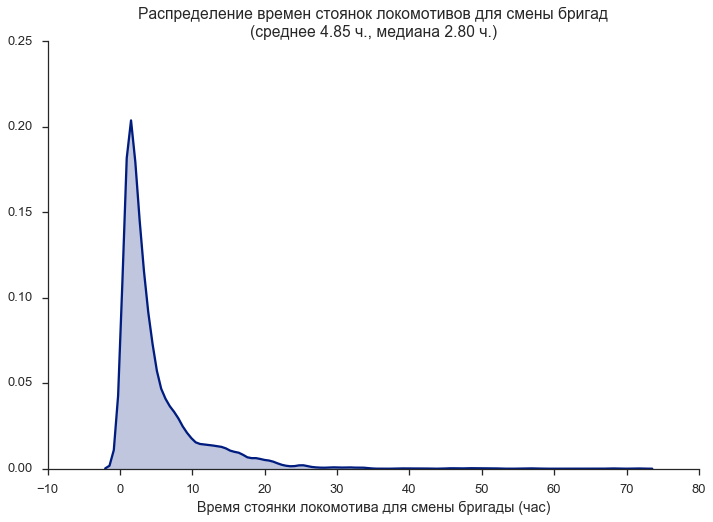

In [131]:
# Смена бригады без стоянки локомотива
cols = ['loco', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'team', 'time_start_next', 'loco_finish', 'stop_time']

loco_plan['team_start'] = (loco_plan.team != loco_plan.team.shift(1)) | (loco_plan.loco != loco_plan.loco.shift(1))
loco_plan['team_end'] = (loco_plan.team != loco_plan.team.shift(-1)) | (loco_plan.loco != loco_plan.loco.shift(-1))
start_teams = loco_plan.loc[(loco_plan.team.isin([-1, 0]) == False) & (loco_plan.team_start == True)].reset_index()\
                            [['loco', 'st_from_name', 'time_start', 'time_start_f', 'train', 'team']]
end_teams = loco_plan.loc[(loco_plan.team.isin([-1, 0]) == False) & (loco_plan.team_end == True)].reset_index()\
                            [['st_to_name', 'time_end', 'time_end_f']]
teams_trip = pd.concat([start_teams, end_teams], axis=1)
teams_trip['time_start_next'] = teams_trip.time_start.shift(-1)
teams_trip['loco_finish'] = teams_trip.loco != teams_trip.loco.shift(-1)
teams_trip.loc[teams_trip.loco_finish == False, 'stop_time'] = teams_trip.time_start_next - teams_trip.time_end
sns.set_style('ticks')
sns.set_context('talk')
sns.set_color_codes('dark')
fig = plt.figure()
series_to_hist = teams_trip.dropna(subset=['stop_time']).stop_time / 3600
#series_to_hist2 = teams_trip.dropna(subset=['stop_time']).loc[(teams_trip.stop_time > 90 * 60)].stop_time / 3600
series_to_hist.name = 'Время стоянки локомотива для смены бригады (час)'
title = 'Распределение времен стоянок локомотивов для смены бригад\n(среднее %.2f ч., медиана %.2f ч.)' %\
        (series_to_hist.mean(), series_to_hist.median())
ax = sns.distplot(series_to_hist, hist_kws={'label':'a'}, color='b', hist=False, kde_kws={'shade':True})
ax.set_title(title)
sns.despine()
filename = 'loco_stop_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Поиск локомотивов, у которых смены бригады занимает меньше 15 минут

In [132]:
#add_line('Время начала планирования' % time.ctime(current_time))
cols2 = ['loco', 'st_from_name', 'st_to_name', 'time_end_f', 'tsn_norm', 'train', 'stop_time', 'team']
pd.set_option('display.max_colwidth', 20)
teams_trip = teams_trip.dropna(subset=['time_start_next'])
teams_trip['tsn_norm'] = teams_trip.time_start_next.apply(lambda x: time.strftime(time_format, time.localtime(x)))
teams_trip.loc[teams_trip.stop_time.isnull() == False, 'next_team'] = teams_trip.team.shift(-1)
teams_trip['train_type'] = teams_trip.train.apply(lambda x: 'Резерв' if str(x)[0]=='8' \
                                                      else ('Задания' if str(x)[0]=='9' else 'Реальный'))
fast_change = teams_trip.loc[teams_trip.stop_time < 15 * 60]
if fast_change.empty == False:
    add_header('Всего %d локомотивов со сменой бригад быстрее 15 минут (показаны первые 10):' % len(fast_change.index))
    add_line(fast_change[cols2].sort_values(['stop_time', 'loco']).head(10))
    add_header('\nРаспределение проблемных локомотивов по станциям смены (показаны первые 10 по частоте):')
    bad_st = fast_change.st_to_name.value_counts().to_frame().reset_index()
    bad_st.columns = ['station', 'freq']
    bad_st['norm_time'] = bad_st['station'].map(stations.drop_duplicates(subset=['name']).set_index('name').norm_time)
    add_line(bad_st.head(10))
    add_header('\nРаспределение проблемных локомотивов по типам поездов:')    
    add_line(fast_change.train_type.value_counts())
else:
    add_line('Нет локомотивов со сменой бригад со стоянкой меньше 15 минут')
    
# Посмотреть маршруты конкретных локомотивов или бригад
loco_cols = ['loco', 'st_from','st_to', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'team']
#team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco']
#print(loco_plan.loc[loco_plan.loco == '200200093307', loco_cols].to_string(index=False))
#print(team_plan.loc[team_plan.loco == '200250042559', team_cols].sort_values('time_start_norm').to_string(index=False))

Всего 72 локомотивов со сменой бригад быстрее 15 минут (показаны первые 10):
         loco  st_from_name    st_to_name     time_end_f       tsn_norm            train  stop_time          team
 200200028549      ГВОЗДЕВО     СУХАНОВКА  Jul 07, 05:07  Jul 07, 05:07     200231587478          0  200200230785
 200200035404  ХАБАРОВСК II  ВОЛОЧАЕВКА I  Jul 07, 10:35  Jul 07, 10:35  999912435012009          0  200200167408
 200200046285  ХАБАРОВСК II          БИРА  Jul 07, 20:26  Jul 07, 20:26   88880016424505          0  777700001354
 200200047258     ЧЕРЕМХОВО     СУХОВСКАЯ  Jul 06, 16:57  Jul 06, 16:57     200231013568          0  200200242813
 200200049020         МЕГЕТ     СУХОВСКАЯ  Jul 07, 08:50  Jul 07, 08:50   88880001094375          0  200200168760
 200200053309       НАХОДКА    ПАРТИЗАНСК  Jul 06, 22:54  Jul 06, 22:54   88880013304595          0  200200164359
 200200064525       ОБЛУЧЬЕ          БИРА  Jul 07, 03:15  Jul 07, 03:15     220206891748          0  777700000264
 2002000665

<a id='rest_time'></a>
## Проверка времен отдыха бригад [ToC](#toc)

In [133]:
add_header('Проверка времен отдыха бригад', h=2, p=False)

In [134]:
add_line('Время начала планирования: %s' % time.strftime(time_format, time.localtime(current_time)))
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state', 'loco']
team_plan['time'] = np.round(((team_plan.time_end - team_plan.time_start) / 3600), 2)
rest_outliers = team_plan[(team_plan.state == 4) & (team_plan.time > 1000)]
add_header('Бригад с аномально большим временем отдыха: %d (показаны первые 10):' % len(rest_outliers.index))
out_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'time', 'state']
if not rest_outliers.empty:
    add_line(rest_outliers[out_cols].head(10))

rest_check = team_plan[(team_plan.state == 4) & (team_plan.time < 1000)]

min_rest = rest_check.time.min()
if min_rest < 3:
    add_header('Минимальное время отдыха (3 часа) нарушено у %d бригад (показаны первые 10):' \
          % len(rest_check[rest_check.time < 3].index))
    add_line(rest_check[rest_check.time < 3][out_cols].head(10))    
else:
    add_header('Минимальное время отдыха бригад: %.2f часа' % (min_rest))

Время начала планирования: Jul 06, 14:41
Бригад с аномально большим временем отдыха: 0 (показаны первые 10):
Минимальное время отдыха (3 часа) нарушено у 1 бригад (показаны первые 10):
         team st_from_name st_to_name   time_start_f     time_end_f  time  state
 200200098272     МАРИИНСК   МАРИИНСК  Jul 06, 14:46  Jul 06, 14:41 -0.08      4


#### Отсев бригад со слишком ранним временем явки

In [135]:
rest_old_presence = rest_check[(rest_check.info_presence < current_time - 12 * 3600) & (rest_check.state_info != '3')]
add_header('Всего %d бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:' 
           % rest_old_presence.team.count())
add_line(rest_old_presence.sort_values('time', ascending=False)[out_cols].head(10))

Всего 483 бригад со слишком большим отдыхом и слишком ранним временем явки (сутки назад и более). Примеры:
         team    st_from_name      st_to_name   time_start_f     time_end_f   time  state
 200200102695     СМОЛЯНИНОВО     СМОЛЯНИНОВО  Jul 06, 04:15  Jul 07, 14:34  34.32      4
 200200152886          АБАКАН          АБАКАН  Jul 06, 08:15  Jul 07, 14:20  30.07      4
 200200235688          РУЖИНО          РУЖИНО  Jul 06, 13:30  Jul 07, 17:31  28.02      4
 200200241719          АБАКАН          АБАКАН  Jul 06, 11:00  Jul 07, 14:20  27.33      4
 200200196518        ГВОЗДЕВО        ГВОЗДЕВО  Jul 06, 13:00  Jul 07, 13:03  24.05      4
 200200140550       ВИХОРЕВКА       ВИХОРЕВКА  Jul 06, 11:13  Jul 07, 10:23  23.18      4
 200200255414       ОЛОВЯННАЯ       ОЛОВЯННАЯ  Jul 06, 13:20  Jul 07, 10:56  21.60      4
 200200100683       ФЕВРАЛЬСК       ФЕВРАЛЬСК  Jul 06, 13:01  Jul 07, 10:30  21.48      4
 200200258792       СИБИРЦЕВО       СИБИРЦЕВО  Jul 06, 11:56  Jul 07, 09:19  21.38 

#### Бригады со слишком большим отдыхом

In [136]:
long_rest = rest_check[(rest_check.time > 10) & (rest_check.team.isin(rest_old_presence.team) == False)]
add_header('Всего %d бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):' % len(long_rest.index))
add_line(long_rest.sort_values('time', ascending=False)[out_cols].head(10))

Всего 194 бригад с большим временем отдыха (больше 10 часов) (показаны первые 10):
         team    st_from_name      st_to_name   time_start_f     time_end_f   time  state
 200200195427     СМОЛЯНИНОВО     СМОЛЯНИНОВО  Jul 06, 14:15  Jul 07, 14:34  24.32      4
 210213067951     БАРАНОВСКИЙ     БАРАНОВСКИЙ  Jul 06, 23:20  Jul 07, 21:37  22.28      4
 200200209989     БАРАНОВСКИЙ     БАРАНОВСКИЙ  Jul 06, 23:20  Jul 07, 21:37  22.28      4
 200200164754     БАРАНОВСКИЙ     БАРАНОВСКИЙ  Jul 06, 23:30  Jul 07, 21:37  22.11      4
 200200250327       ФЕВРАЛЬСК       ФЕВРАЛЬСК  Jul 06, 12:53  Jul 07, 10:30  21.62      4
 200200260609    ВЫСОКОГОРНАЯ    ВЫСОКОГОРНАЯ  Jul 06, 20:26  Jul 07, 17:53  21.45      4
 200200145702  РАЗЪЕЗД 557 КМ  РАЗЪЕЗД 557 КМ  Jul 06, 20:47  Jul 07, 18:13  21.43      4
 200200162043     СМОЛЯНИНОВО     СМОЛЯНИНОВО  Jul 06, 17:11  Jul 07, 14:34  21.37      4
 200200144639    БЕЛОГОРСК II    БЕЛОГОРСК II  Jul 07, 21:41  Jul 08, 18:05  20.39      4
 200200153402    

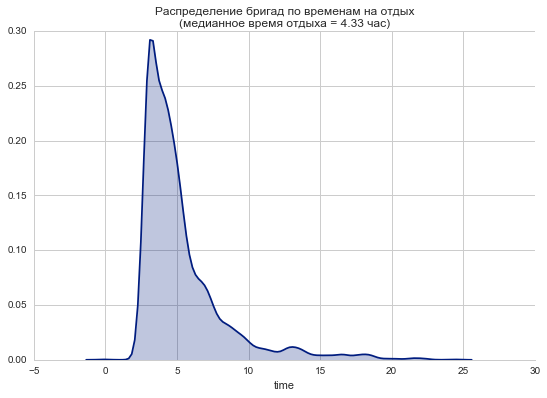

In [137]:
rest_show = rest_check[(rest_check.team.isin(rest_old_presence.team) == False)]
title = 'Распределение бригад по временам на отдых\n(медианное время отдыха = %.2f час)' % (rest_show.time.median())
sns.set_style('whitegrid')
sns.set_context('notebook')
fig = plt.figure()
ax = sns.distplot(rest_show.time, hist=False, kde_kws={'shade':True}, color='b')
ax.set(title=title)
sns.despine()
filename = 'team_rest_time.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

#### Бригады с недостаточным отдыхом

In [138]:
rest = team_plan[team_plan.state == 4][['team', 'time_start', 'time']]
team_trips['rest_start_time'] = team_trips.team.map(rest.set_index('team').time_start)
team_trips['rest_start_time_f'] = team_trips.rest_start_time\
                .apply(lambda x: time.strftime(time_format, time.localtime(x)) if np.isnan(x) == False else '')
team_trips['rest_time'] = team_trips.team.map(rest.set_index('team').time)
team_trips['min_rest_time'] = np.round((team_trips.rest_start_time - team_trips.curr_presence) / (2 * 3600), 2)
team_trips['underrest'] = team_trips.min_rest_time - team_trips.rest_time

In [139]:
# Для подсчета требуемого отдыха удаляем поездки, которые связаны с одной явкой бригады; 
# для каждой явки оставляем только последнюю поездку, чтобы правильно взять полное рабочее время.
team_trips_cut = team_trips.sort_values(['team', 'curr_presence', 'work_time'], ascending=[True, True, False])\
                            .drop_duplicates(subset=['team', 'curr_presence'])

In [140]:
cols = ['team', 'curr_presence_norm', 'time_start_f', 'rest_start_time_f', 
        'work_time', 'min_rest_time', 'rest_time', 'underrest']
underrest = team_trips_cut[(team_trips_cut.time_start < team_trips_cut.rest_start_time) & (team_trips_cut.underrest > 0)]
underrest_n = underrest.team.drop_duplicates().count()
add_header('Всего %d бригад с недостаточным отдыхом:' % underrest_n)
add_header('Распределение по типу бригад:')
add_line(underrest.team_type.value_counts())

Всего 810 бригад с недостаточным отдыхом:
Распределение по типу бригад:
Реальная    546
Фейковая    264


Всего 701 бригад без переработки с недостаточным отдыхом.

Распределение по типу бригад:
Реальная    462
Фейковая    239

Примеры бригад без переработки с недостаточным отдыхом:
         team curr_presence_norm   time_start_f rest_start_time_f  work_time  min_rest_time  rest_time  underrest
 200200254705      Jul 07, 00:30  Jul 07, 00:50     Jul 07, 14:55       2.76           7.20       3.00       4.20
 200200266353      Jul 06, 12:40  Jul 06, 17:30     Jul 06, 23:12      10.04           5.27       3.00       2.27
 200200091441      Jul 06, 13:37  Jul 06, 17:10     Jul 06, 23:37       9.50           5.00       3.67       1.33
 200200225972      Jul 07, 00:47  Jul 07, 02:17     Jul 07, 11:06       3.75           5.17       3.87       1.30
 200200218983      Jul 07, 00:47  Jul 07, 02:17     Jul 07, 11:06       3.75           5.17       3.87       1.30
 200200103092      Jul 07, 00:47  Jul 07, 02:17     Jul 07, 11:06       3.75           5.17       3.87       1.30
 200200154333      Jul 0

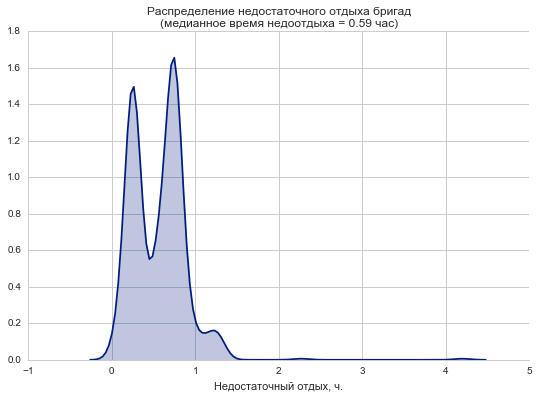

In [141]:
underrest_no_overtime = underrest[underrest.work_time <= WORK_TIME_LIMIT]
underrest_no_n = underrest_no_overtime.team.drop_duplicates().count()
add_header('Всего %d бригад без переработки с недостаточным отдыхом.' % underrest_no_n)
add_header('\nРаспределение по типу бригад:')
add_line(underrest_no_overtime.team_type.value_counts())
add_header('\nПримеры бригад без переработки с недостаточным отдыхом:')
add_line(underrest_no_overtime.sort_values('underrest', ascending=False).head(10 if underrest_no_n > 20 else underrest_no_n)[cols])

sns.set_context('notebook')
sns.set_style('whitegrid')
title = 'Распределение недостаточного отдыха бригад\n(медианное время недоотдыха = %.2f час)' \
            % (underrest_no_overtime.underrest.median())
fig = plt.figure()
ax = sns.distplot(underrest_no_overtime.underrest, color='b', hist=False, kde_kws={'shade':True})
ax.set(title=title, xlabel='Недостаточный отдых, ч.')
sns.despine()
filename = 'team_under_rest.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [142]:
team_plan['loco_time'] = list(zip(team_plan.loco, team_plan.time_start))
loco_plan['loco_time'] = list(zip(loco_plan.loco, loco_plan.time_start))
team_plan['train'] = team_plan.loco_time.map(loco_plan.drop_duplicates('loco_time').set_index('loco_time').train)
#print(team_plan[team_plan.team == '777700000270']\
#      [['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 
#        'state', 'loco', 'train', 'time']].to_string(index=False))
time.ctime(1463065200)

'Thu May 12 18:00:00 2016'

## Проверка подвязки бригад по Иркутску

In [143]:
add_header('Анализ бригад, проезжающих через Иркутск', h=2, p=False)

In [144]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'depot_name']
team_plan['depot_name'] = team_plan.depot.map(st_names.name)
st_name = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
train_cols = ['train', 'number', 'st_from_name', 'st_to_name', 'time_start_f']
train_plan['train_type'] = train_plan.train.apply(lambda x: str(x)[:1])
add_header('Распределение поездов через Иркутск по направлениям:')
add_line(train_plan.loc[(train_plan.st_from_name == st_name)
              & (train_plan.time_start >= current_time) & (train_plan.train_type.isin(['2', '9']))
              & (train_plan.time_start < current_time + 24*3600), train_cols].st_to_name.value_counts())

add_header('\nРаспределение бригад, в маршруте которых есть Иркутск, по депо приписки:')
b = team_plan.loc[(team_plan.st_from_name == st_name) & (team_plan.state.isin([0, 1]))
              & (team_plan.time_start >= current_time), team_cols].groupby('depot_name').team.count().to_frame()
b['percent'] = np.round((100 * b.team / b.team.sum()), 2)
b['percent'] = b['percent'].apply(lambda x: str(x) + '%')
add_line(b.reset_index())

Распределение поездов через Иркутск по направлениям:
ГОНЧАРОВО     71
БАТАРЕЙНАЯ    42

Распределение бригад, в маршруте которых есть Иркутск, по депо приписки:
          depot_name  team percent
                ЗИМА    75  49.02%
 ИРКУТСК-СОРТИРОВ...    57  37.25%
         НИЖНЕУДИНСК     1   0.65%
          СЛЮДЯНКА I    18  11.76%
            УЛАН-УДЭ     2   1.31%


<a id='ready_time'></a>
## Проверка времени явки бригад [ToC](#toc)

In [145]:
add_header('Проверка корректости времен явки бригад в депо приписки во входных данных', h=2, p=False)

1. У бригад, которые находятся на домашнем отдыхе (state = 3) передается именно время ухода на отдых. По постановке (см. раздел "Заполнение атрибутов для входных сообщений по бригадам") должно передаваться время ухода на отдых + 16 часов.
2. Для бригады 200200158216 передается state=3, хотя по АСУ-Т последней операцией на 18.04 10:35 было "прибытие на станцию Лесовозный 17.04 в 08:49" (или, в крайнем случае, отправление с Улан-Удэ 17.04 в 07:51).
3. Аналогично для бригады 200200225600. Впрочем, возможно, это какой-то косяк АСУ-Т. В любом случае, пункт 1 - это очевидный баг.

Общая идея:
- если у бригад указано depot_time < rest_start_time, то эта разница не должна быть очень большой. 
- если у бригад указано depot_time < return_time, то эта разница тоже не должна быть очень большой.

In [146]:
add_line('Время начала планирования: %s' % (time.strftime(time_format, time.localtime(current_time))))
team_info['dt_norm'] = team_info.depot_time.apply(lambda x: time.strftime(time_format, time.localtime(x)) if x > 0 else x)
team_info['rt_norm'] = team_info.return_time.apply(lambda x: time.strftime(time_format, time.localtime(x)) if x > 0 else x)
team_info['rst_norm'] = team_info.rest_time.apply(lambda x: time.strftime(time_format, time.localtime(x)) if x > 0 else x)
team_info['rest_dep_delta'] = np.round(((team_info.rest_time - team_info.depot_time) / 3600), 2)
team_info['return_dep_delta'] = np.round(((team_info.return_time - team_info.depot_time) / 3600), 2)

dep_less_rest = team_info[(team_info.depot_time < team_info.rest_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'rest_dep_delta', 'ready_type', 'state']
add_header('Всего %d бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:' 
          % dep_less_rest[dep_less_rest.rest_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_rest[dep_less_rest.rest_dep_delta > 12][info_cols].sort_values('rest_dep_delta', ascending=False).head(10))

dep_less_return = team_info[(team_info.depot_time < team_info.return_time) & (team_info.dt_norm != -1)]
info_cols = ['team', 'number', 'dt_norm', 'rst_norm', 'return_dep_delta', 'ready_type', 'state']
add_header('\nВсего %d бригад, у которых время последней явки в депо намного меньше (на 18+ часов) времени явки в пункте оборота. Примеры:' 
          % dep_less_return[dep_less_return.return_dep_delta > 12].team.drop_duplicates().count())
add_line(dep_less_return[dep_less_return.return_dep_delta > 12][info_cols].sort_values('return_dep_delta', ascending=False).head(10))

Время начала планирования: Jul 06, 14:41
Всего 272 бригад, у которых время последней явки в депо намного меньше (на 12+ часов) переданного времени начала отдыха. Примеры:
         team      number        dt_norm       rst_norm  rest_dep_delta ready_type state
 200200140550  9209009656  Jul 04, 12:52  Jul 06, 11:13           46.35     return     4
 200200255414  9413047233  Jul 04, 23:30  Jul 06, 13:20           37.83     return     4
 200200224994  9403014461  Jul 05, 00:40  Jul 06, 09:00           32.33     return     4
 200200224532  9403002213  Jul 05, 00:40  Jul 06, 08:31           31.85     return     4
 200200168453  9403023827  Jul 05, 02:00  Jul 06, 09:00           31.00     return     4
 200200083038  9413015182  Jul 04, 22:10  Jul 06, 03:11           29.02     return     9
 200200196518  9606003264  Jul 05, 08:00  Jul 06, 13:00           29.00     return     4
 200200281922  9401059241  Jul 04, 23:20  Jul 06, 04:00           28.67     return     1
 200200102035  9403020050  J

<a id='change'></a>
## Проверка смены бригад на корректных станциях [ToC](#toc)

In [147]:
add_header('Проверка смены бригад на корректных станциях', h=2, p=False)

### Проверка случаев проезда бригад мимо станций обязательной смены

In [148]:
add_header('Проверка проезда бригад мимо станций обязательной смены', h=3, p=False)

In [149]:
st_team_change_full = ['КРАСНОЯРСК-ВОСТОЧНЫЙ', 'ЗИМА', 'ХИЛОК', 'МОГОЧА', 'ОБЛУЧЬЕ', 'РУЖИНО', 'СМОЛЯНИНОВО', 
                      'САЯНСКАЯ', 'ЛЕНА', 'СЕВЕРОБАЙКАЛЬСК', 'НОВЫЙ УОЯН', 
                      'НОВАЯ ЧАРА', 'ЮКТАЛИ', 'ВЕРХНЕЗЕЙСК', 'ФЕВРАЛЬСК', 'ПОСТЫШЕВО', 'ВЫСОКОГОРНАЯ', 
                      'УЖУР', 'ТЫРМА']
                 
cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'state', 'loco', 'loco_end', 'no_stop']
team_plan['loco_end'] = team_plan.loco != team_plan.loco.shift(-1)
team_plan['no_stop'] = team_plan.time_end == team_plan.time_start.shift(-1)
no_stop = team_plan[(team_plan.st_to_name.isin(st_team_change_full)) & (team_plan.state == 1) 
                    & (team_plan.loco_end == False) & (team_plan.no_stop == True)]
add_header('Всего %d случаев проезда бригад мимо станций обязательной смены' % len(no_stop.index))
add_header('\nРаспределение по станциям (первые 5 самых частых):')
add_line(no_stop.st_to_name.value_counts().head())

Всего 99 случаев проезда бригад мимо станций обязательной смены

Распределение по станциям (первые 5 самых частых):
ЗИМА          39
ХИЛОК         18
РУЖИНО        17
САЯНСКАЯ       8
НОВЫЙ УОЯН     5


In [150]:
add_header('\nПримеры ошибочных бригад (первые 10):')
add_line(no_stop.drop_duplicates('st_to_name').sort_values('time_end')[cols])


Примеры ошибочных бригад (первые 10):
         team      st_from_name    st_to_name   time_start_f     time_end_f  state          loco loco_end no_stop
 200200107781        НОВОНЕЖИНО   СМОЛЯНИНОВО  Jul 06, 15:20  Jul 06, 15:45      1  200200104912    False    True
 200200131758            ЯКУРИМ          ЛЕНА  Jul 06, 15:40  Jul 06, 15:49      1  200200139339    False    True
 200200222979          МОНГОХТО  ВЫСОКОГОРНАЯ  Jul 06, 17:25  Jul 06, 22:17      1  200200102593    False    True
 200200151826         ЩЕТИНКИНО      САЯНСКАЯ  Jul 06, 23:26  Jul 07, 02:18      1  200200091345    False    True
 200200173285         АНГАРАКАН    НОВЫЙ УОЯН  Jul 07, 11:26  Jul 07, 13:31      1  200200057086    False    True
 777700000776             ТИСИН          УЖУР  Jul 07, 11:42  Jul 07, 14:09      1  200200093671    False    True
 777700002166       ИЗВЕСТКОВАЯ       ОБЛУЧЬЕ  Jul 07, 15:16  Jul 07, 16:07      1  200200087120    False    True
 777700001341          ТАЛАНДЖА         ТЫРМА  Ju

#### Причины проезда бригад мимо станций смены:

1. Новый Уоян: у бригад в участках обкатки присутствует участок 2002118258 (Северобайкальск -- Таксимо). Возможное решение: проверить участки обкатки, выяснить, откуда берется участок обкатки Северобайкальск -- Таксимо, удалить этот участок при необходимости.
2. Красноярск-Восточный: бригадам хватает рабочего времени, чтобы проехать на участке Ачинск I -- Иланская. Возможное решение: реализовать справочник нормативных рабочих времен бригад, указать в нем время работы на участках Ачинск -- Красноярск и Красноярск -- Иланская около 7-8 часов.
3. Ружино: у бригад указан участок обкатки Хабаровск II -- Уссурийск. Но есть ошибка в планировщике с расчетом рабочего времени бригад (VP-6162).

### Проверка случаев смены бригад не на допустимых станциях

In [151]:
add_header('Проверка случаев смены бригад не на допустимых станциях', h=3, p=False)

In [152]:
add_line('Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда' + 
         ', а также случаи смены бригады на станции, которая является депо приписки бригады')

Исключаются случаи смены бригады из-за завершения маршрута локомотива или поезда, а также случаи смены бригады на станции, которая является депо приписки бригады


In [153]:
#loco_plan['loco_end'] = loco_plan.loco != loco_plan.loco.shift(-1)
#train_ends = train_plan.drop_duplicates('train', keep='last')[['train', 'st_to_name']].set_index('train')
#loco_plan['train_end'] = loco_plan.train.map(train_ends.st_to_name) == loco_plan.st_to_name
loco_plan['end_trip'] = (loco_plan.state != loco_plan.state.shift(-1)) | (loco_plan.train != loco_plan.train.shift(-1))\
                        | (loco_plan.loco != loco_plan.loco.shift(-1))
team_plan['start_station_name'] = team_plan.team.map(team_plan[team_plan.state.isin([0, 1])]\
                                                     .drop_duplicates('team').set_index('team').st_from_name)
team_plan.depot_name.fillna(team_plan.start_station_name, inplace=True)
team_plan['depot_st_name'] = team_plan.depot_st.map(st_names.name)
team_plan.depot_st_name.fillna(team_plan.start_station_name, inplace=True)
loco_plan['team_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_name)
loco_plan['team_ready_depot_name'] = loco_plan.team.map(team_plan.drop_duplicates('team').set_index('team').depot_st_name)

In [154]:
pr_st = pd.read_csv(FOLDER + 'mandatory/priority_team_change_stations.csv', sep=';', encoding='utf-8-sig', dtype={'station':str}).station
#team_change = loco_plan[(loco_plan.state != 4) 
#                        & (loco_plan.team_end == True) & (loco_plan.loco_end == False) & (loco_plan.train_end == False)]
team_change = loco_plan[(loco_plan.state != 4) & (loco_plan.team_end == True) & (loco_plan.end_trip == False)]
bad_team_change = team_change[(team_change.st_to.isin(pr_st) == False) 
                              & (team_change.st_to_name != team_change.team_depot_name)
                              & (team_change.st_to_name != team_change.team_ready_depot_name)]
if bad_team_change.st_to_name.dropna().empty:
    add_header('Все бригады меняются только на приоритетных станциях смены')
else:
    add_header('Всего %d случаев смены бригад не на приоритетных станциях смены (%.2f%%)'
              % (bad_team_change.loco.count(), 100 * bad_team_change.loco.count() / team_change.loco.count()))
    add_header('Распределение по неприоритетным станциям (первые 10):')
    add_line(bad_team_change.st_to_name.value_counts().head(10))   
    

Все бригады меняются только на приоритетных станциях смены


In [155]:
with (pd.option_context('display.max_colwidth', 20)):
    if not bad_team_change.st_to_name.dropna().empty:
        add_header('Примеры локомотивов и бригад, для которых смена указанной бригады произошла не на приоритетной станции:')
        add_line(bad_team_change[['loco', 'team', 'st_to_name', 'time_end_f', 'train']].head(10))
        cols = ['loco', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'train', 'team', 'team_depot_name']        
        loco_id = bad_team_change[bad_team_change.st_to_name == bad_team_change.st_to_name.value_counts().idxmax()]\
                    .drop_duplicates('loco').iloc[0,:].loco
        add_header('Полный план по одному из таких локомотивов:')
        add_line(loco_plan[loco_plan.loco == loco_id][cols])

<a id='presence'></a>
## Проверка отправления бригады не ранее времени явки [ToC](#toc)

In [156]:
add_header('Проверка отправления бригады не ранее времени явки', h=2, p=False)

In [157]:
# Вычисляем максимальное время явки, добавляем его в team_info и team_plan
# В таблице presence_fail --- ошибочные отправления бригад до времени явки

presence_lim = 0
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'ready_type', 
             'presence_norm', 'presence_gap', 'state', 'state_info']

team_info['all_presence'] = list(zip(team_info.depot_time, team_info.return_time))
team_info['presence'] = team_info.all_presence.apply(lambda x: x[0] if x[0] > x[1] else x[1])
team_info['presence_norm'] = team_info.presence.apply(lambda x: time.strftime(time_format, time.localtime(x)) if x>0 else x)
team_plan['presence'] = team_plan.team.map(team_info.set_index('team').presence)
team_plan['presence_norm'] = team_plan.presence.apply(lambda x: time.strftime(time_format, time.localtime(x)) if x>0 else x)
team_plan['presence_gap'] = team_plan.time_start - team_plan.presence
team_plan['ready_type'] = team_plan.team.map(team_info.set_index('team').ready_type)
presence_fail = team_plan[(team_plan.state.isin([0, 1])) & (team_plan.presence_gap < presence_lim)].drop_duplicates('team')
pr = team_info[['team', 'depot_time', 'return_time', 'presence', 'presence_norm']]

In [165]:
p = presence_fail[presence_fail.state == 0]
ph = presence_fail[(presence_fail.state == 0) & (presence_fail.time_start >= current_time)]
if not p.empty:
    add_header('Всего бригад, которые отправлены пассажиром ранее времени явки: %d (показаны первые 10)' % p.team.count())
    add_line(p.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки')
    
if not ph.empty:
    add_header('\nВсего бригад, которые отправлены пассажиром ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % ph.team.count())
    add_line(ph.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования')

Нет бригад, которые запланированы к отправлению пассажиром ранее времени явки

Нет бригад, которые запланированы к отправлению пассажирами ранее времени явки после начала планирования


In [164]:
f = presence_fail[presence_fail.state == 1]
fh = presence_fail[(presence_fail.state == 1) & (presence_fail.time_start >= current_time)]
if not f.empty:
    add_header('Всего бригад, которые отправлены с локомотивом ранее времени явки: %d (показаны первые 10)' % f.team.count())
    add_line(f.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки')

if not fh.team.empty:
    add_header('\nВсего бригад, которые отправлены с локомотивом ранее времени явки после начала планирования: %d (показаны первые 10)' 
      % fh.team.count())
    add_line(fh.sort_values('presence_gap')[team_cols].head(10))
else:
    add_header('\nНет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования')

Всего бригад, которые отправлены с локомотивом ранее времени явки: 1 (показаны первые 10)
         team st_from_name st_to_name   time_start_f ready_type  presence_norm  presence_gap  state state_info
 200200245998     САЯНСКАЯ  ЩЕТИНКИНО  Jul 06, 03:37     return  Jul 06, 10:20        -24180      1          1
Нет бригад, которые запланированы к отправлению с локомотивами ранее времени явки после начала планирования


<a id='before_current_time'></a>
## Проверка планирования бригад до времени начала планирования [ToC](#toc)

In [68]:
add_header('Проверка планирования бригад до времени начала планирования', h=2, p=False)

In [69]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco', 'state_info']

add_line('(Не учитываются бригады, которые на начало планирования находились на перегоне)')
add_line('Время начала планирования: %s' % time.strftime(time_format, time.localtime(current_time)))

total_teams = team_plan.team.drop_duplicates().count()

tbef = team_plan[(team_plan.time_start < current_time)          
         & (team_plan.state.isin([0, 1])) & (team_plan.state_info != team_plan.state.apply(str))].drop_duplicates('team')
add_header('\nВсего бригад, отправленных до начала планирования: %d (%.2f%% от всех запланированных бригад)' 
           % (tbef.team.count(), 100 * tbef.team.count() / total_teams))
if not tbef.empty:
    add_header('\nРаспределение по состояниям бригад, отправленных до начала планирования:')
    add_line(tbef.state.value_counts())
    
    for i in sorted(tbef.state.unique()):
        add_header('\nБригады, отправленные до начала планирования в состоянии %d (первые 10):' % i)
        add_line(tbef[tbef.state == i].sort_values('time_start').head(10)[team_cols])

    add_header('\nРаспределение по типу бригад, отправленных до начала планирования в состоянии 1:')
    add_line(tbef[tbef.state == 1].team_type.value_counts())

(Не учитываются бригады, которые на начало планирования находились на перегоне)
Время начала планирования: Jul 06, 14:41

Всего бригад, отправленных до начала планирования: 0 (0.00% от всех запланированных бригад)


<a id='presenting'></a>
## Проверка планируемых явок бригад [ToC](#toc)

In [70]:
add_header('Проверка планируемых явок бригад', h=2, p=False)

Разброс времен на явку бригад: от 0.32 ч. до 5.90 ч.


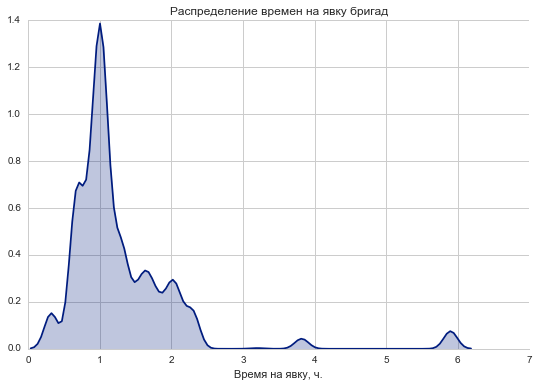

In [71]:
team_cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'tt', 'state', 'loco', 'state_info']
team_plan['tt'] = team_plan.time_end - team_plan.time_start
min_presenting = team_plan[team_plan.state == 2][team_cols].tt.min()
max_presenting = team_plan[team_plan.state == 2][team_cols].tt.max()
add_header('Разброс времен на явку бригад: от %.2f ч. до %.2f ч.' % (min_presenting / 3600, max_presenting / 3600))
sns.set_style('whitegrid')
sns.set_context('notebook')
fig = plt.figure()
ax = sns.distplot(team_plan[team_plan.state == 2][team_cols].tt / 3600, hist=False, bins=20, color='b', kde_kws={'shade':True})
ax.set(xlabel='Время на явку, ч.', title='Распределение времен на явку бригад')
sns.despine()
filename = 'team_presenting.png'
fig.savefig(REPORT_FOLDER + filename, bbox_inches='tight')
add_image(filename)

In [72]:
team_plan['next_state'] = team_plan.state.shift(-1)
team_plan['next_time_start_f'] = team_plan.time_start_f.shift(-1)
cols = ['team', 'st_from_name', 'st_to_name', 'state', 'next_state', 'time_start_f', 'time_end_f', 'next_time_start_f']
rest_pres = team_plan[(team_plan.team == team_plan.team.shift(-1)) 
                     & (team_plan.state == 4) & (team_plan.next_state == 2)
                     & (team_plan.time_end_f != team_plan.next_time_start_f)]
add_header('Всего %d бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):' 
      % rest_pres.team.drop_duplicates().count())
add_line(rest_pres[rest_pres.time_start >= current_time].sort_values('time_start').head(10)[cols])
add_header('\nРаспределение таких ошибочных явок после отдыха по станциям (показаны первые 5):')
add_line(rest_pres.st_from_name.value_counts().head())

Всего 1126 бригад, у которых время окончания отдыха не совпадает со временем явки (показаны первые 10):
         team  st_from_name    st_to_name  state  next_state   time_start_f     time_end_f next_time_start_f
 200200280971     КАРЫМСКАЯ     КАРЫМСКАЯ      4           2  Jul 06, 14:42  Jul 06, 17:42     Jul 06, 18:34
 200200133588         УРУША         УРУША      4           2  Jul 06, 14:42  Jul 06, 17:42     Jul 06, 23:59
 200200260896  ХАБАРОВСК II  ХАБАРОВСК II      4           2  Jul 06, 14:42  Jul 06, 18:59     Jul 06, 20:05
 200200175944     МАГДАГАЧИ     МАГДАГАЧИ      4           2  Jul 06, 14:45  Jul 06, 18:48     Jul 06, 19:15
 200200131243      УЛАН-УДЭ      УЛАН-УДЭ      4           2  Jul 06, 14:46  Jul 06, 18:34     Jul 07, 00:13
 200200212284     БЕЛОГОРСК     БЕЛОГОРСК      4           2  Jul 06, 14:46  Jul 06, 17:46     Jul 06, 19:04
 210207676311      УЛАН-УДЭ      УЛАН-УДЭ      4           2  Jul 06, 14:46  Jul 06, 17:46     Jul 06, 19:13
 200200224568      МАРИИ

<a id='check_useful_assign'></a>
## Проверка использования бригад [ToC](#toc)

In [73]:
add_header('Проверка использования бригад', h=2, p=False)

<a id='only_pass'></a>
### Бригады, запланированные к отправлению пассажирами без последующей подвязки [ToC](#toc)

In [74]:
add_header('Проверка использования бригад после засылки пассажирами', h=3, p=False)

In [75]:
team_plan['all_states'] = team_plan.team.map(team_plan.groupby('team').state.unique())
#team_plan['last_state'] = team_plan.team.map(team_plan
#                                             .sort_values(['team', 'time_start'], ascending=[True, False])
#                                             .drop_duplicates('team')[['team', 'state']]
#                                             .set_index('team')
#                                             .state)

#team_plan['first_state'] = team_plan.team.map(team_plan
#                                             .sort_values(['team', 'time_start'])
#                                             .drop_duplicates('team')[['team', 'state']]
#                                             .set_index('team')
#                                             .state)

cols = ['team', 'st_from_name', 'st_to_name', 'time_start_f', 'time_end_f', 'depot_name',
        'state', 'all_states']

In [76]:
def get_cat(all_states):
    if 1 in all_states:
        return 'work'
    elif (len(all_states) == 1) & (all_states[0] == 2):
        return 'only_presence'
    elif len(all_states) == 2:
        if ((all_states[0] == 4) & (all_states[1] == 0)):
            return 'pass_home'
        else:
            return 'fail'
    else:
        return 'fail'

team_plan['cat'] = team_plan.all_states.apply(get_cat)
only_pass_teams = team_plan[(team_plan.cat == 'fail') & (team_plan.state_info != '2')]
                            
add_header('Всего %d бригад, для которых планируется отправка пассажиром и не планируется работа с поездом' 
      % only_pass_teams.team.drop_duplicates().count())

Всего 398 бригад, для которых планируется отправка пассажиром и не планируется работа с поездом


In [77]:
add_header('Станции, с которых чаще всегда планируется лишняя отправка пассажирами:')
add_line(only_pass_teams.drop_duplicates('team').st_from_name.value_counts().head(10))

Станции, с которых чаще всегда планируется лишняя отправка пассажирами:
ИЛАНСКАЯ                              124
КРАСНОЯРСК-ВОСТОЧНЫЙ                   86
НИЖНЕУДИНСК                            26
ТЫНДА                                  23
КОРШУНИХА-АНГАРСКАЯ                    18
ЛЕНА                                   14
КОМСОМОЛЬСК-НА-АМУРЕ-СОРТИРОВОЧНЫЙ     12
СЕВЕРОБАЙКАЛЬСК                        11
УЛАН-УДЭ                                9
СМОЛЯНИНОВО                             8


In [78]:
with pd.option_context('display.max_colwidth', 25):
    if only_pass_teams.team.drop_duplicates().count() != 0:
        add_header('Примеры:')
        for team in only_pass_teams.team.drop_duplicates().iloc[:3].values:    
            add_line(team_plan[team_plan.team == team][cols])
            add_line('')

Примеры:
         team st_from_name st_to_name   time_start_f     time_end_f depot_name  state all_states
 200200164081     ИЛАНСКАЯ     РЕШОТЫ  Jul 07, 02:49  Jul 07, 03:58   ИЛАНСКАЯ      0     [0, 4]
 200200164081       РЕШОТЫ      КЛЮЧИ  Jul 07, 03:59  Jul 07, 04:14   ИЛАНСКАЯ      0     [0, 4]
 200200164081        КЛЮЧИ       ЮРТЫ  Jul 07, 04:14  Jul 07, 04:35   ИЛАНСКАЯ      0     [0, 4]
 200200164081         ЮРТЫ     ТАЙШЕТ  Jul 07, 04:37  Jul 07, 04:58   ИЛАНСКАЯ      0     [0, 4]
 200200164081       ТАЙШЕТ     ТАЙШЕТ  Jul 07, 05:28  Jul 07, 12:30   ИЛАНСКАЯ      4     [0, 4]
 200200164081       ТАЙШЕТ       ЮРТЫ  Jul 07, 12:30  Jul 07, 12:50   ИЛАНСКАЯ      0     [0, 4]
 200200164081         ЮРТЫ      КЛЮЧИ  Jul 07, 12:50  Jul 07, 13:12   ИЛАНСКАЯ      0     [0, 4]
 200200164081        КЛЮЧИ     РЕШОТЫ  Jul 07, 13:12  Jul 07, 13:26   ИЛАНСКАЯ      0     [0, 4]
 200200164081       РЕШОТЫ   ИЛАНСКАЯ  Jul 07, 13:27  Jul 07, 14:31   ИЛАНСКАЯ      0     [0, 4]

         team st_fro

In [79]:
irk = only_pass_teams[only_pass_teams.st_from_name == 'ИРКУТСК-СОРТИРОВОЧНЫЙ']
if not irk.empty:
    add_header('Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:')
    add_line(team_plan[team_plan.team == irk.iloc[0].team][cols])

Пример бесцельной отправки пассажиром со станции Иркутск-Сортировочный:
         team         st_from_name           st_to_name   time_start_f     time_end_f           depot_name  state all_states
 200200260598  ИРКУТСК-СОРТИРОВ...           БАТАРЕЙНАЯ  Jul 07, 02:24  Jul 07, 02:26  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 200200260598           БАТАРЕЙНАЯ                МЕГЕТ  Jul 07, 02:26  Jul 07, 02:34  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 200200260598                МЕГЕТ            СУХОВСКАЯ  Jul 07, 02:34  Jul 07, 02:46  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 200200260598            СУХОВСКАЯ      СУХОВСКАЯ-ЮЖНАЯ  Jul 07, 02:46  Jul 07, 03:00  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 200200260598      СУХОВСКАЯ-ЮЖНАЯ      СУХОВСКАЯ-ЮЖНАЯ  Jul 07, 03:30  Jul 07, 07:30  ИРКУТСК-СОРТИРОВ...      4     [0, 4]
 200200260598      СУХОВСКАЯ-ЮЖНАЯ            СУХОВСКАЯ  Jul 07, 07:30  Jul 07, 07:44  ИРКУТСК-СОРТИРОВ...      0     [0, 4]
 200200260598            СУХОВСКАЯ                МЕГ

<a id='only_presence'></a>
### Бригады, планируемые только на явку [ToC](#toc)

In [80]:
add_header('Бригады, планируемые только на явку', h=3, p=False)

In [91]:
cols = ['team', 'st_from_name', 'time_start_f', 'time_end_f', 'depot_name', 'state_info', 'all_states']
only_pr = team_plan[team_plan.cat == 'only_presence']
if not only_pr.empty:
    add_header('Всего %d бригад, запланированных только на явку.' % only_pr.team.drop_duplicates().count())
    add_line('')
    add_header('Распределение по депо станции явки:')
    add_line(only_pr.drop_duplicates('team').st_from_name.value_counts().head())
    add_line('')
    add_header('Распределение по типу бригады:')
    add_line(only_pr.drop_duplicates('team').team_type.value_counts())
    add_line('')
    add_header('Примеры бригад:')
    add_line(only_pr[cols].head(10))
else:
    add_header('В плане нет бригад, запланированных только на явку')

Всего 768 бригад, запланированных только на явку.

Распределение по депо станции явки:
МОГОЧА                  113
ИЛАНСКАЯ                109
КРАСНОЯРСК-ВОСТОЧНЫЙ     89
ФЕВРАЛЬСК                71
КАРЫМСКАЯ                35

Распределение по типу бригады:
Фейковая    584
Реальная    184

Примеры бригад:
         team         st_from_name   time_start_f     time_end_f           depot_name state_info all_states
 200200164070            КАРЫМСКАЯ  Jul 06, 10:54  Jul 06, 13:00            КАРЫМСКАЯ          2        [2]
 200200136330           НОВАЯ ЧАРА  Jul 06, 04:09  Jul 06, 06:00           НОВАЯ ЧАРА          2        [2]
 200200242540  ЧЕРНЫШЕВСК-ЗАБАЙ...  Jul 06, 09:45  Jul 06, 10:37  ЧЕРНЫШЕВСК-ЗАБАЙ...          2        [2]
 200200127618                ХИЛОК  Jul 05, 22:01  Jul 05, 23:10                ХИЛОК          2        [2]
 200200163975          НОВЫЙ УРГАЛ  Jul 06, 11:47  Jul 06, 13:47          НОВЫЙ УРГАЛ          2        [2]
 777700002953               МОГОЧА  Jul 06, 

<a id='pass_teams_in_plan'></a>
## Проверка подвязки негрузовых бригад [ToC](#toc)

In [82]:
add_header('Проверка подвязки негрузовых бригад', h=2, p=False)

In [83]:
cols = ['team', 'ttype', 'loco_info', 'st_from_name', 'st_to_name', 'time_start_f', 'state', 'loco']
bad_pass_teams = team_plan[(team_plan.ttype == 0) & (team_plan.loco != team_plan.loco_info) 
                           & (team_plan.state.isin([0, 1]))][cols]
if bad_pass_teams.empty:
    add_header('В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных')
else:
    add_header('Всего %d негрузовых бригад, для которых запланирована подвязка, отличная от подвязки во входных данных:' 
              % bad_pass_teams.drop_duplicates('team').team.count())
    add_line(bad_pass_teams.drop_duplicates('team')[cols].head())

В плане нет негрузовых бригад с запланированной подвязкой, отличной от подвязки во входных данных


## Экспорт в HTML [ToC](#toc)

In [84]:
filename = REPORT_FOLDER + 'team_report_' + time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time())) + '.html'
create_report(filename)

Отчет сформирован: report/team_report_20160707_171659.html
